# PCA Improves knn on Face Recognition

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.datasets import fetch_lfw_people

In [3]:
people = fetch_lfw_people(min_faces_per_person=20, resize=0.7)

In [4]:
image_shape = people.images[0].shape
image_shape

(87, 65)

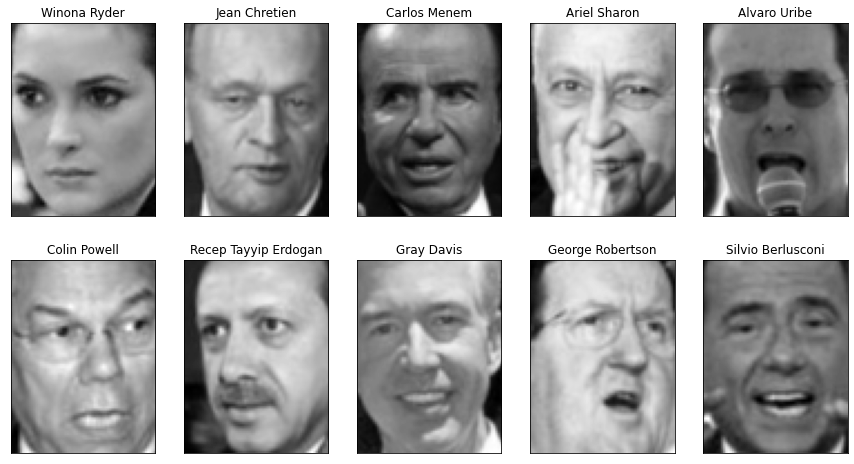

In [5]:
fig, axes = plt.subplots(2, 5, figsize=(15,8), subplot_kw={'xticks':(), 'yticks':()})
for target, image, ax in zip(people.target, people.images, axes.ravel()):
    ax.imshow(image, cmap='gray')
    ax.set_title(people.target_names[target])

In [6]:
counts = np.bincount(people.target)
counts

array([ 39,  35,  21,  36,  20,  77,  42,  24,  29,  21, 236,  31, 121,
        22, 530, 109,  44,  26,  30,  22,  39,  71,  20,  28,  52,  55,
        21,  42,  21,  24,  20,  53,  31,  23,  28,  60,  32,  41,  22,
        41,  48,  29,  33,  20,  22,  37,  20,  22,  30,  27,  32,  26,
        23,  52,  33,  23,  25,  33, 144,  32,  49,  24])

In [7]:
len(counts), len(people.target_names)

(62, 62)

In [8]:
for i, (count, name) in enumerate(zip(counts, people.target_names)):
    print("{0:3} {1:25} {2:3}".format(i, name, count), end='   ')
    if (i + 1) % 3 == 0:
        print()

  0 Alejandro Toledo           39     1 Alvaro Uribe               35     2 Amelie Mauresmo            21   
  3 Andre Agassi               36     4 Angelina Jolie             20     5 Ariel Sharon               77   
  6 Arnold Schwarzenegger      42     7 Atal Bihari Vajpayee       24     8 Bill Clinton               29   
  9 Carlos Menem               21    10 Colin Powell              236    11 David Beckham              31   
 12 Donald Rumsfeld           121    13 George Robertson           22    14 George W Bush             530   
 15 Gerhard Schroeder         109    16 Gloria Macapagal Arroyo    44    17 Gray Davis                 26   
 18 Guillermo Coria            30    19 Hamid Karzai               22    20 Hans Blix                  39   
 21 Hugo Chavez                71    22 Igor Ivanov                20    23 Jack Straw                 28   
 24 Jacques Chirac             52    25 Jean Chretien              55    26 Jennifer Aniston           21   
 27 Jennifer Capria

In [9]:
mask = np.zeros(people.target.shape, dtype=np.bool)
for target in np.unique(people.target):
    mask[np.where(people.target == target)[0][:50]] = 1

In [10]:
len(mask), mask[-10:]

(3023,
 array([ True,  True, False, False,  True,  True, False, False, False,
        False]))

In [11]:
X_people = people.data[mask]
y_people = people.target[mask]

In [12]:
X_people.shape, people.data.shape

((2063, 5655), (3023, 5655))

In [13]:
X_people = X_people / 255.

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

# split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_people, y_people, stratify=y_people, random_state=0)

In [15]:
# build a KNeighborsClassifier using one neighbor
knn1 = KNeighborsClassifier(n_neighbors=1)
knn1.fit(X_train, y_train)
score1 = knn1.score(X_test, y_test)
print(f"Test set score of 1-nn: {score1:.2f}")

Test set score of 1-nn: 0.23


## save and load the model

In [16]:
import pickle

In [17]:
with open('knn1.pkl', 'wb') as model_file:
    pickle.dump(knn1, model_file)

In [18]:
with open('knn1.pkl', 'rb') as model_file:
    model = pickle.load(model_file)

In [19]:
type(model)

sklearn.neighbors._classification.KNeighborsClassifier

In [20]:
model.score(X_test, y_test)

0.23255813953488372

## PCA

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=100, whiten=True, random_state=0).fit(X_train)
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

print("X_train_pca.shape: {X_train_pca.shape}")

X_train_pca.shape: {X_train_pca.shape}


In [22]:
knn2 = KNeighborsClassifier(n_neighbors=1)
knn2.fit(X_train_pca, y_train)
score2 = knn2.score(X_test_pca, y_test)
print(f"Test set accuracy: {score2:.2f}")

Test set accuracy: 0.31


In [23]:
print(f"improvement: {100*(score2 - score1)/score1:.2f}%")

improvement: 34.17%


## comparison

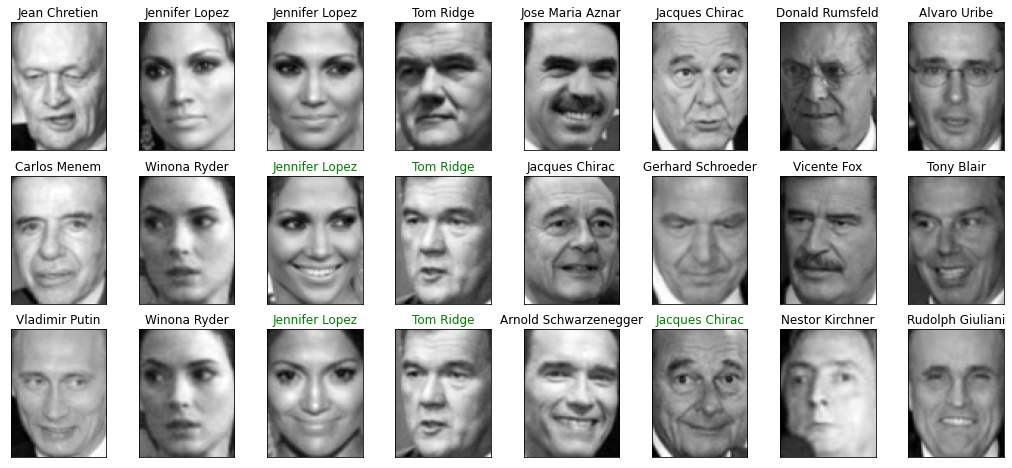

In [24]:
n_neighbors = 8
neighbors1 = knn1.kneighbors(X_test[0:n_neighbors])
neighbors2 = knn2.kneighbors(X_test_pca[0:n_neighbors])
fig, axes = plt.subplots(3, n_neighbors, figsize=(18, 8), subplot_kw={'xticks': (), 'yticks': ()})
for i in range(n_neighbors):
    axes[0][i].imshow(X_test[i].reshape(image_shape), cmap='gray')
    title = people.target_names[y_test[i]]
    axes[0][i].set_title(title)
    axes[1][i].imshow(X_train[neighbors1[1][i]].reshape(image_shape), cmap='gray')
    title1 = people.target_names[y_train[neighbors1[1][i]][0]]
    if title1 == title:
        axes[1][i].set_title(title1, color='green')
    else:
        axes[1][i].set_title(title1)
    axes[2][i].imshow(X_train[neighbors2[1][i]].reshape(image_shape), cmap='gray')
    title2 = people.target_names[y_train[neighbors2[1][i]][0]]
    if title2 == title:
        axes[2][i].set_title(title2, color='green')    
    else:
        axes[2][i].set_title(title2)            

## What does the PCA components look like?

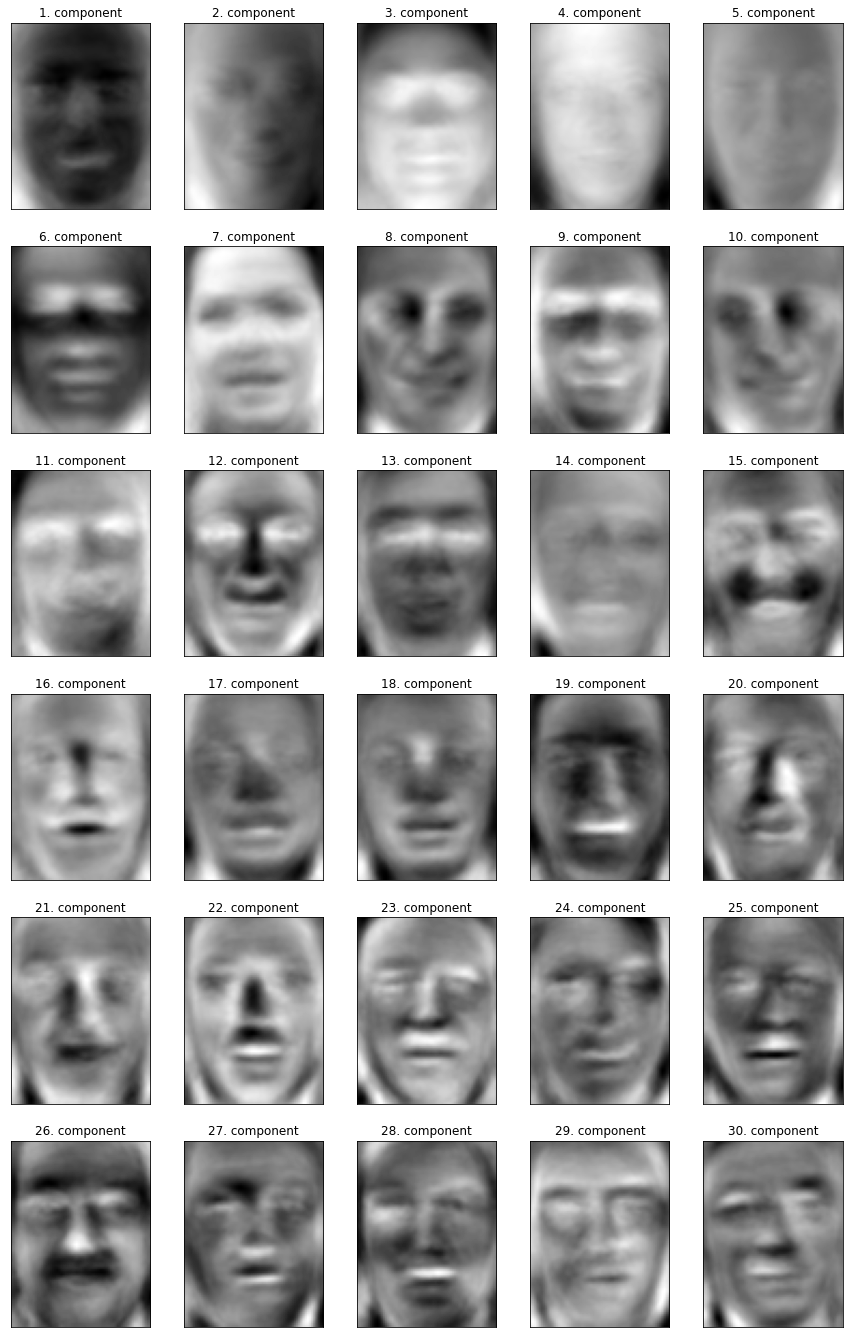

In [25]:
fig, axes = plt.subplots(6, 5, figsize=(15, 24),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, (component, ax) in enumerate(zip(pca.components_, axes.ravel())):
    ax.imshow(component.reshape(image_shape),
              cmap='gray')
    ax.set_title("{}. component".format((i + 1)))

## reconstruct faces

In [26]:
def pca_faces(X_train, X_test):
    # copy and pasted from nmf. refactor?
    # Build NMF models with 10, 50, 100, 500 components
    # this list will hold the back-transformd test-data
    reduced_images = []
    for n_components in [10, 50, 100, 500]:
        # build the NMF model
        pca = PCA(n_components=n_components)
        pca.fit(X_train)
        # transform the test data (afterwards has n_components many dimensions)
        X_test_pca = pca.transform(X_test)
        # back-transform the transformed test-data
        # (afterwards it's in the original space again)
        X_test_back = pca.inverse_transform(X_test_pca)
        reduced_images.append(X_test_back)
    return reduced_images

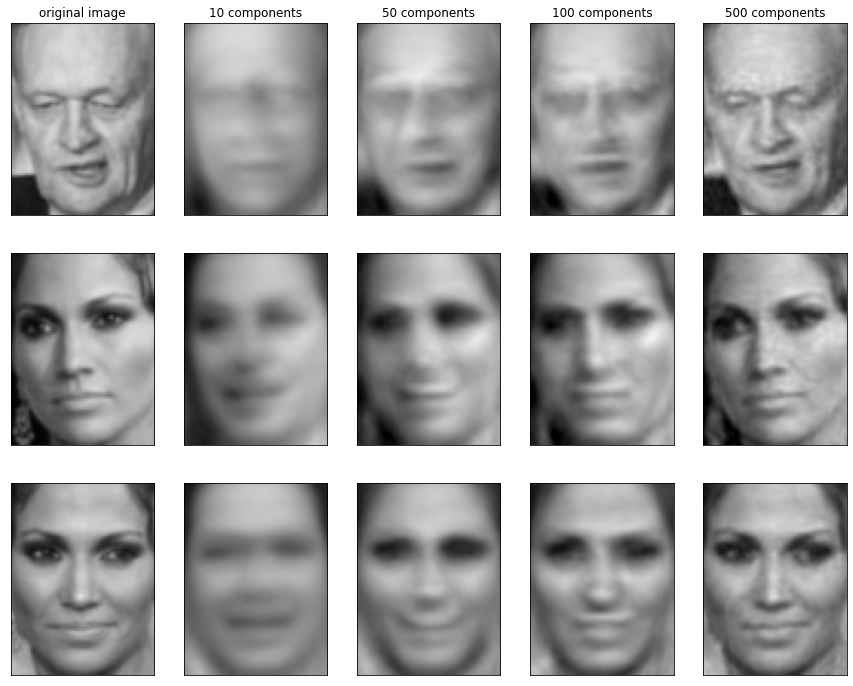

In [27]:
reduced_images = pca_faces(X_train, X_test)

# plot the first three images in the test set:
fix, axes = plt.subplots(3, 5, figsize=(15, 12),
                         subplot_kw={'xticks': (), 'yticks': ()})
for i, ax in enumerate(axes):
    # plot original image
    ax[0].imshow(X_test[i].reshape(image_shape), cmap='gray',
                 vmin=0, vmax=1)
    # plot the four back-transformed images
    for a, X_test_back in zip(ax[1:], reduced_images):
        a.imshow(X_test_back[i].reshape(image_shape), vmin=0, vmax=1, cmap='gray')

# label the top row
axes[0, 0].set_title("original image")
for ax, n_components in zip(axes[0, 1:], [10, 50, 100, 500]):
    ax.set_title("%d components" % n_components)
plt.show()